##Scope and Objective

URL for the dataset:https://www.kaggle.com/datasets/prasad22/retail-transactions-dataset/

Scope: retail stores purchases during 3 years(since the begining of 2020).This includes total items and total cost of each pruchase,city and store type where purchase was made and whether some king of customer engagements were used to entice a customer

Objective: maximize total cost to achieve more profit


Problem is that we want to open a supermarket, however we do not know which type of store we should open and which promotionto use(and use it or not) , in order to engage with our customers and get more profit.

## Data preprocess


In [ ]:
#Importing modules
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import sklearn.metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


In [ ]:
#Reading CSV file
file_path = 'Retail_Transactions_Dataset.csv'
df = pd.read_csv(file_path)
df.head()




,Transaction_ID,Date,Customer_Name,Product,Total_Items,Total_Cost,Payment_Method,City,Store_Type,Discount_Applied,Customer_Category,Season,Promotion
0,1000000000,2020-12-21 19:42:52,Cheyenne Newman,['Hair Gel'],6,12.77,Debit Card,New York,Convenience Store,True,Student,Winter,None
1,1000000001,2020-07-06 07:45:16,Emily Fitzgerald,"['Tuna', 'Bread', 'Tissues', 'Trash Bags']",5,13.88,Debit Card,Houston,Supermarket,False,Professional,Fall,BOGO (Buy One Get One)
2,1000000002,2021-10-02 06:28:44,Michael Webb,"['Jam', 'Soap', 'Ketchup']",7,47.02,Debit Card,Miami,Convenience Store,False,Young Adult,Winter,None
3,1000000003,2022-01-10 05:39:02,Kimberly Lin,['BBQ Sauce'],9,83.86,Mobile Payment,Seattle,Warehouse Club,True,Senior Citizen,Summer,Discount on Selected Items
4,1000000004,2021-10-13 07:28:47,Cathy Hernandez,"['Hand Sanitizer', 'Bread', 'Extension Cords',...",4,30.55,Debit Card,Houston,Warehouse Club,False,Senior Citizen,Spring,None


In [ ]:
# As we are trying to find patterns, one time purchasers is not really interested for us
df = df[df.duplicated(subset='Customer_Name', keep=False)]

In [ ]:
#Investigating data type of each column
df.dtypes



Transaction_ID         int64
Date                  object
Customer_Name         object
Product               object
Total_Items            int64
Total_Cost           float64
Payment_Method        object
City                  object
Store_Type            object
Discount_Applied        bool
Customer_Category     object
Season                object
Promotion             object
dtype: object

In [ ]:
#Checking for missing values
missing_values_count = df.isnull().sum()
print("Missing Values in Each Column:")
print(missing_values_count)
#Checking for duplicated rows(so we don't have all columns in a row equal to another row)
duplicate_rows = df.duplicated()
duplicate_rows_count = duplicate_rows.sum()
print("Duplicated rows:", duplicate_rows_count)

Missing Values in Each Column:
Transaction_ID       0
Date                 0
Customer_Name        0
Product              0
Total_Items          0
Total_Cost           0
Payment_Method       0
City                 0
Store_Type           0
Discount_Applied     0
Customer_Category    0
Season               0
Promotion            0
dtype: int64
Duplicated rows: 0


In [ ]:
# Deleting unnecessary columns
columns_to_drop = ['Transaction_ID','Payment_Method','City']
df = df.drop(columns = columns_to_drop)

In [ ]:
#Checking all unique values inside each column
print("Store type unique", df['Store_Type'].unique())
print("Customer category unique", df['Customer_Category'].unique())
print("Promotion", df['Promotion'].unique())
print("Product type", df['Product'].unique())

Store type unique ['Supermarket' 'Convenience Store' 'Warehouse Club' 'Specialty Store'
 'Department Store' 'Pharmacy']
Customer category unique ['Professional' 'Young Adult' 'Teenager' 'Senior Citizen' 'Retiree'
 'Middle-Aged' 'Student' 'Homemaker']
Promotion ['BOGO (Buy One Get One)' 'None' 'Discount on Selected Items']
Product type ["['Tuna', 'Bread', 'Tissues', 'Trash Bags']" "['Jam', 'Soap', 'Ketchup']"
 "['Shower Gel', 'Baby Wipes', 'Banana', 'Paper Towels']" ...
 "['Air Freshener', 'Spinach', 'BBQ Sauce', 'Banana']"
 "['Cleaning Spray', 'Iron', 'Tea', 'Mayonnaise', 'Feminine Hygiene Products']"
 "['Trash Cans', 'Shrimp', 'Garden Hose', 'Tuna']"]


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7181 entries, 1 to 29982
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               7181 non-null   object 
 1   Customer_Name      7181 non-null   object 
 2   Product            7181 non-null   object 
 3   Total_Items        7181 non-null   int64  
 4   Total_Cost         7181 non-null   float64
 5   Store_Type         7181 non-null   object 
 6   Discount_Applied   7181 non-null   bool   
 7   Customer_Category  7181 non-null   object 
 8   Season             7181 non-null   object 
 9   Promotion          7181 non-null   object 
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 568.0+ KB


In [ ]:
df['Discount_Applied'] = df['Discount_Applied'].astype(int)
df['Discount_Applied'] = df['Discount_Applied'].replace({False: 0, True: 1})
df['Discount_Applied'].fillna(0, inplace=True)
season_mapping = {'Winter': 1, 'Spring': 2, 'Summer': 3, 'Fall': 4}
df['Season_numeric'] = df['Season'].map(season_mapping)

Store_Types = {'Convenience Store': 1, 'Supermarket': 2, 'Warehouse Club': 3, 'Pharmacy': 4, 'Specialty Store': 5, 'Department Store': 6}
df['Store_numeric'] = df['Store_Type'].map(Store_Types)

Customer_Category = {'Student': 1, 'Professional': 2, 'Young Adult': 3, 'Senior Citizen': 4, 'Teenager': 5, 'Middle-Aged': 6, 'Retiree': 7, 'Homemaker': 8}
df['Customer_Category_numeric'] = df['Customer_Category'].map(Customer_Category)
season_dummies = pd.get_dummies(df['Season_numeric'], prefix='Season')
store_dummies = pd.get_dummies(df['Store_numeric'], prefix='Store')
customer_dummies = pd.get_dummies(df['Customer_Category_numeric'], prefix='Customer_Category')
df = pd.concat([df, season_dummies, store_dummies, customer_dummies], axis=1)
df = df.drop(['Store_Type', 'Customer_Category', 'Store_numeric', 'Customer_Category_numeric', 'Season', 'Season_numeric'], axis=1)
column_mapping = {
    'Season_1':'Winter',
    'Season_2' :'Spring',
    'Season_3':'Summer',
    'Season_4' :'Fall',
    'Store_1':'Convenience Store',
    'Store_2' :'Supermarket',
    'Store_3' :'Warehouse Club',
    'Store_4' :'Pharmacy',
    'Store_5' :'Specialty Store',
    'Store_6':'Department Store',
    'Customer_Category_1' :'Student',
    'Customer_Category_2':'Professional',
    'Customer_Category_3':'Young Adult',
    'Customer_Category_4':'Senior Citizen',
    'Customer_Category_5' :'Teenager',
    'Customer_Category_6':'Middle-Aged',
    'Customer_Category_7' :'Retiree',
    'Customer_Category_8':'Homemaker',
}

df.rename(columns=column_mapping, inplace=True)


In [ ]:
import pandas as pd

# ... (assuming you've already loaded your dataframe df)

# Convert 'Discount_Applied' to int and handle missing values
df['Discount_Applied'] = df['Discount_Applied'].astype(int)
df['Discount_Applied'] = df['Discount_Applied'].replace({False: 0, True: 1})
df['Discount_Applied'].fillna(0, inplace=True)

# Create numerical mappings for categorical variables
season_mapping = {'Winter': 1, 'Spring': 2, 'Summer': 3, 'Fall': 4}
store_mapping = {'Convenience Store': 1, 'Supermarket': 2, 'Warehouse Club': 3, 'Pharmacy': 4, 'Specialty Store': 5, 'Department Store': 6}
customer_mapping = {'Student': 1, 'Professional': 2, 'Young Adult': 3, 'Senior Citizen': 4, 'Teenager': 5, 'Middle-Aged': 6, 'Retiree': 7, 'Homemaker': 8}

# Apply mappings
df['Season_numeric'] = df['Season'].map(season_mapping)
df['Store_numeric'] = df['Store_Type'].map(store_mapping)
df['Customer_Category_numeric'] = df['Customer_Category'].map(customer_mapping)

# Create dummy variables and drop one to avoid the dummy variable trap
season_dummies = pd.get_dummies(df['Season_numeric'], prefix='Season', drop_first=True)
store_dummies = pd.get_dummies(df['Store_numeric'], prefix='Store', drop_first=True)
customer_dummies = pd.get_dummies(df['Customer_Category_numeric'], prefix='Customer_Category', drop_first=True)


# Concatenate dummy variables to the dataframe
df = pd.concat([df, season_dummies, store_dummies, customer_dummies], axis=1)

# Drop original categorical columns and numerical mappings
df = df.drop(['Store_Type', 'Customer_Category', 'Season', 'Season_numeric', 'Store_numeric', 'Customer_Category_numeric'], axis=1)

column_mapping = {
    'Season_1':'Winter',
    'Season_2' :'Spring',
    'Season_3':'Summer',
    'Season_4' :'Fall',
    'Store_1':'Convenience Store',
    'Store_2' :'Supermarket',
    'Store_3' :'Warehouse Club',
    'Store_4' :'Pharmacy',
    'Store_5' :'Specialty Store',
    'Store_6':'Department Store',
    'Customer_Category_1' :'Student',
    'Customer_Category_2':'Professional',
    'Customer_Category_3':'Young Adult',
    'Customer_Category_4':'Senior Citizen',
    'Customer_Category_5' :'Teenager',
    'Customer_Category_6':'Middle-Aged',
    'Customer_Category_7' :'Retiree',
    'Customer_Category_8':'Homemaker',
}

df.rename(columns=column_mapping, inplace=True)

In [ ]:
import pandas as pd

# ... (assuming you've already loaded your dataframe df)

# Convert 'Discount_Applied' to int and handle missing values
df['Discount_Applied'] = df['Discount_Applied'].astype(int)
df['Discount_Applied'] = df['Discount_Applied'].replace({False: 0, True: 1})
df['Discount_Applied'].fillna(0, inplace=True)

# Create numerical mappings for categorical variables
season_mapping = {'Winter': 1, 'Spring': 2, 'Summer': 3, 'Fall': 4}
store_mapping = {'Convenience Store': 1, 'Supermarket': 2, 'Warehouse Club': 3, 'Pharmacy': 4, 'Specialty Store': 5, 'Department Store': 6}
customer_mapping = {'Student': 1, 'Professional': 2, 'Young Adult': 3, 'Senior Citizen': 4, 'Teenager': 5, 'Middle-Aged': 6, 'Retiree': 7, 'Homemaker': 8}

# Apply mappings
df['Season_numeric'] = df['Season'].map(season_mapping)
df['Store_numeric'] = df['Store_Type'].map(store_mapping)
df['Customer_Category_numeric'] = df['Customer_Category'].map(customer_mapping)

df = df.drop(['Store_Type', 'Customer_Category','Season'], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7181 entries, 1 to 29982
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               7181 non-null   object 
 1   Customer_Name      7181 non-null   object 
 2   Product            7181 non-null   object 
 3   Total_Items        7181 non-null   int64  
 4   Total_Cost         7181 non-null   float64
 5   Store_Type         7181 non-null   object 
 6   Discount_Applied   7181 non-null   bool   
 7   Customer_Category  7181 non-null   object 
 8   Season             7181 non-null   object 
 9   Promotion          7181 non-null   object 
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 568.0+ KB


In [ ]:
df.head()

,Date,Customer_Name,Product,Total_Items,Total_Cost,Discount_Applied,Promotion,Season_numeric,Store_numeric,Customer_Category_numeric
1,2020-07-06 07:45:16,Emily Fitzgerald,"['Tuna', 'Bread', 'Tissues', 'Trash Bags']",5,13.88,0,BOGO (Buy One Get One),4,2,2
2,2021-10-02 06:28:44,Michael Webb,"['Jam', 'Soap', 'Ketchup']",7,47.02,0,None,1,1,3
5,2021-04-26 20:45:13,Elizabeth Cook,"['Shower Gel', 'Baby Wipes', 'Banana', 'Paper ...",10,30.19,1,None,3,2,5
8,2020-03-05 23:47:29,Christopher Wang,"['Banana', 'Pickles']",2,20.04,0,Discount on Selected Items,1,3,5
10,2023-05-10 16:20:28,Samantha Mcclure,"['Shrimp', 'Soda']",3,28.43,1,None,2,5,3


##Exploratory data analysis.

In [ ]:
# Check relationship with season
selected_columns = ['Discount_Applied','Product', 'Total_Items', 'Total_Cost','Spring','Summer','Fall']
correlation_matrix = df[selected_columns].corr()
sns.heatmap(correlation_matrix.iloc[:3, 3:], annot=True, cmap='coolwarm')
plt.title('Correlation Matrix with Season')

KeyError: ignored

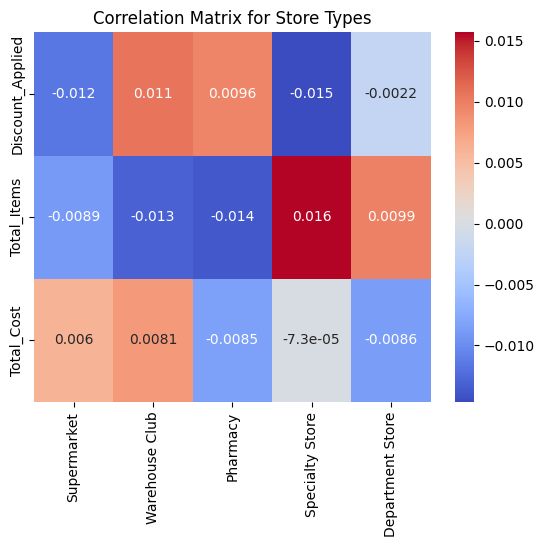

In [ ]:
#Creating correlation matrix to see relationships  with type of store
selected_columns = ['Discount_Applied', 'Total_Items', 'Total_Cost', 'Supermarket', 'Warehouse Club', 'Pharmacy', 'Specialty Store','Department Store']
correlation_matrix = df[selected_columns].corr()
sns.heatmap(correlation_matrix.iloc[:3, 3:], annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Store Types')
plt.show()

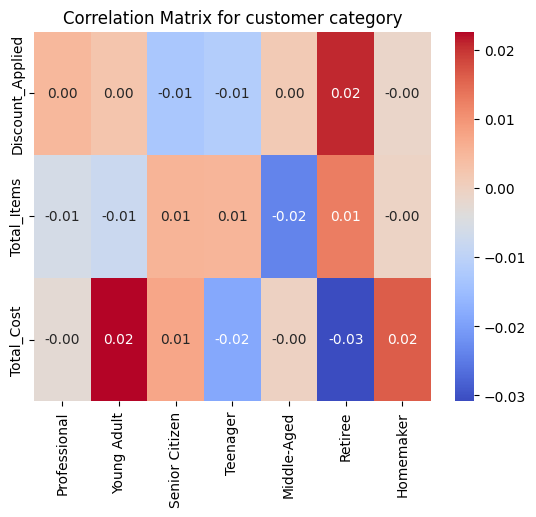

In [ ]:
# Check relationship with customer category
selected_columns = ['Discount_Applied', 'Total_Items', 'Total_Cost', 'Professional', 'Young Adult', 'Senior Citizen', 'Teenager', 'Middle-Aged', 'Retiree','Homemaker']
correlation_matrix = df[selected_columns].corr()
sns.heatmap(correlation_matrix.iloc[:3, 3:], annot=True, cmap='coolwarm',fmt=".2f")#only two digits displayed by using fmt=".2f"
plt.title('Correlation Matrix for customer category')
plt.show()

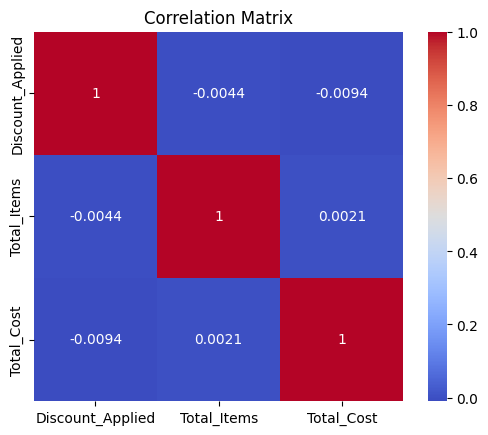

In [ ]:
# Check relationship between variables using correlation Matrix
selected_columns = ['Discount_Applied', 'Total_Items', 'Total_Cost',]
correlation_matrix = df[selected_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

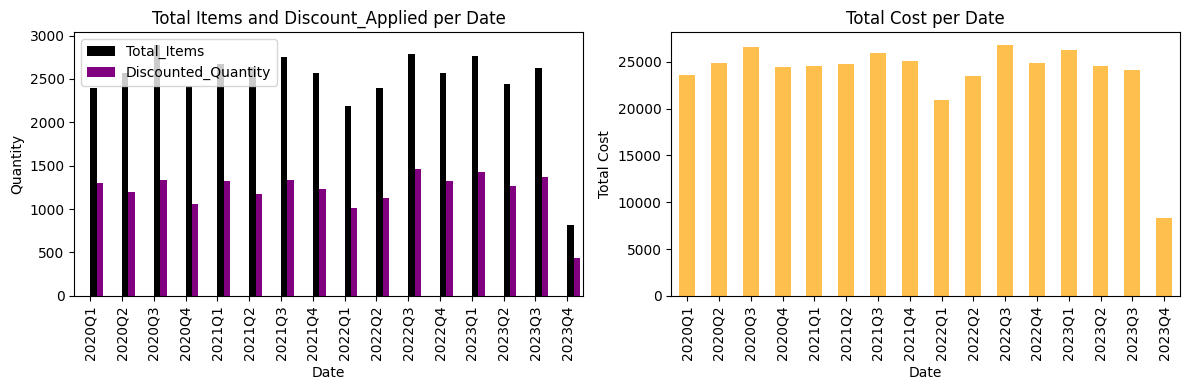

In [ ]:
#Understanding how much product were purchased and on which amount by each quarter
df['Date'] = pd.to_datetime(df['Date'], format='%Y %m %d')
df['Date'] = df['Date'].dt.to_period('Q')

#multiplying discount by items sold because for items sold at 1 time discount was applied(as we are considering 1 discount product  as whole purchase to be discounted)
df['Discounted_Quantity'] = df['Total_Items'] * df['Discount_Applied']

#Grouping items, to display them on a graph
daily_totals_items = df.groupby('Date')[['Total_Items', 'Discounted_Quantity']].sum()
daily_totals_cost = df.groupby('Date')['Total_Cost'].sum()

#building place for graphs, so that they will be displayed next to each other
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=True)


# first plot is describing how much items were sold during quarter and which ammount of them was sold with discount
daily_totals_items.plot(kind='bar', ax=axes[0], color=['black', 'purple'], width=0.4, position=0, align='center', label=['Total Items', 'Discounted_Quantity'])
axes[0].set_ylabel('Quantity')
axes[0].set_title('Total Items and Discount_Applied per Date')
axes[0].legend(loc='upper left')

# This plot tells total cost of products sold in each period
daily_totals_cost.plot(kind='bar', ax=axes[1], color='orange', alpha=0.7)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Total Cost')
axes[1].set_title('Total Cost per Date')

plt.tight_layout()
plt.show()











##Problem solving

In [ ]:
# Check for missing values
print(df.isnull().sum())
column_types = df.dtypes

# Filter columns that are not of type float
non_float_columns = column_types[column_types != float]

# Display the non-float columns
print("Columns with non-float types:")
print(non_float_columns)

Date                         0
Customer_Name                0
Product                      0
Total_Items                  0
Total_Cost                   0
Discount_Applied             0
Promotion                    0
Season_numeric               0
Store_numeric                0
Customer_Category_numeric    0
Discounted_Quantity          0
dtype: int64
Columns with non-float types:
Date                         period[Q-DEC]
Customer_Name                       object
Product                             object
Total_Items                          int64
Discount_Applied                     int64
Promotion                           object
Season_numeric                       int64
Store_numeric                        int64
Customer_Category_numeric            int64
Discounted_Quantity                  int64
dtype: object


In [ ]:
df.head()

,Total_Items,Total_Cost,Store_Type,Discount_Applied,Customer_Category,Season,Season_numeric,Store_numeric,Customer_Category_numeric
1,5,13.88,Supermarket,0,Professional,Fall,4,2,2
2,7,47.02,Convenience Store,0,Young Adult,Winter,1,1,3
5,10,30.19,Supermarket,1,Teenager,Summer,3,2,5
8,2,20.04,Warehouse Club,0,Teenager,Winter,1,3,5
10,3,28.43,Specialty Store,1,Young Adult,Spring,2,5,3


In [ ]:
columns_to_normalize = ['Total_Cost', 'Total_Items']

# Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Fit and transform the selected columns
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Display the normalized DataFrame
print(df.head())

                   Date     Customer_Name  \
1   2020-07-06 07:45:16  Emily Fitzgerald   
2   2021-10-02 06:28:44      Michael Webb   
5   2021-04-26 20:45:13    Elizabeth Cook   
8   2020-03-05 23:47:29  Christopher Wang   
10  2023-05-10 16:20:28  Samantha Mcclure   

                                              Product  Total_Items  \
1          ['Tuna', 'Bread', 'Tissues', 'Trash Bags']     0.444444   
2                          ['Jam', 'Soap', 'Ketchup']     0.666667   
5   ['Shower Gel', 'Baby Wipes', 'Banana', 'Paper ...     1.000000   
8                               ['Banana', 'Pickles']     0.111111   
10                                 ['Shrimp', 'Soda']     0.222222   

    Total_Cost  Discount_Applied                   Promotion  Winter  Spring  \
1     0.093493                 0      BOGO (Buy One Get One)       0       0   
2     0.442409                 0                        None       1       0   
5     0.265214                 1                        None       0

In [ ]:
#Preparation before applying data mining techniques
columns_to_drop = ['Date','Customer_Name','Product','Promotion']
df = df.drop(columns = columns_to_drop)
x = df.drop('Total_Cost',axis=1)            # separate objective column
y =df['Total_Cost']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) #Splitting dataset to train machine on data and then test correctness of the data predicted by machine


In [ ]:
df.head()

,Total_Items,Total_Cost,Discount_Applied,Winter,Spring,Summer,Fall,Convenience Store,Supermarket,Warehouse Club,...,Specialty Store,Department Store,Student,Professional,Young Adult,Senior Citizen,Teenager,Middle-Aged,Retiree,Homemaker
1,0.444444,0.093493,0,0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,0.666667,0.442409,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
5,1.000000,0.265214,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
8,0.111111,0.158349,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
10,0.222222,0.246684,1,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


In [ ]:
#Lasso Method

In [ ]:
#Evaluation metrics for Lasso Method

In [ ]:
#Ridge regression

In [ ]:
#Evaluation metrics for Ridge regression

In [ ]:
#Linear Regression


param_grid = {                                                       # Choosing best parametrs for the regression
    'fit_intercept': [True, False],  # Whether to calculate intercept of this model
    'positive': [True, False],  # forces the coefficients to be positive
}
reg = LinearRegression()
grid_search = GridSearchCV(reg,param_grid,cv=5,scoring = 'r2',n_jobs = -1)
grid_search.fit(x_train,y_train)
best_params = grid_search.best_params_
print("Best Params:",best_params)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

KeyboardInterrupt: ignored

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

# Assuming x_train, x_test, y_train, y_test are your training and testing sets

param_grid = {
    'alpha': [0.1, 1.0, 10.0],  # Regularization strength (higher values mean more regularization)
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
}

ridge = Ridge()
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
print("Best Params:", best_params)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

# Evaluate the model using R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')

results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Display the DataFrame with actual and predicted values
print(results_df)

Best Params: {'alpha': 10.0, 'fit_intercept': True, 'solver': 'lsqr'}
R-squared: 0.0013705858815238336
Mean Squared Error: 760.9929477545256
       Actual  Predicted
9490    87.95  52.494446
12040   22.51  52.511483
16091    6.68  52.458180
16165   15.53  51.456209
24876   38.82  52.646656
...       ...        ...
24617   10.27  51.814180
3875    31.64  53.538413
16274   14.01  52.819896
29463   46.96  53.295290
1878    64.57  53.569255

[1437 rows x 2 columns]


In [ ]:
#Evaluation metrics for Linear Regression
r2 = r2_score(y_test,y_pred)
print("r2 is :",r2)


r2 is : -0.0012132215547200342


##Evaluation